In [2]:
import pandas as pd

# Chemin vers le fichier Excel d'entrée
chemin_fichier = r"C:\Users\andde\Documents\S C O L A I R E\I N S A\5A\PIRD\Etude expérimentale\Scénarios\Regroupement résultats 2.0\Données_combinees.xlsx"

# Charger le fichier Excel, ignorer les colonnes "Unnamed"
data = pd.read_excel(chemin_fichier)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Colonnes principales (fixes)
colonnes_principales = ['Date/Heure', 'Température Sèche Air Extérieur', 'Scénario']

# Extraire les colonnes des zones et indicateurs
colonnes_zones = [col for col in data.columns if col not in colonnes_principales]

# Créer une liste pour stocker les nouvelles données restructurées
donnees_restructurees = []

# Parcourir chaque ligne pour transformer les données
for index, row in data.iterrows():
    for colonne in colonnes_zones:
        zone, indicateur = colonne.split(' ', 1)  # Diviser par le premier espace
        donnees_restructurees.append({
            'Date/Heure': row['Date/Heure'],
            'Température Sèche': row['Température Sèche Air Extérieur'],
            'Scénario': row['Scénario'],
            'Zone': zone,
            'Indicateur': indicateur,
            'Valeur': row[colonne]
        })

# Convertir la liste en DataFrame
df_restructure = pd.DataFrame(donnees_restructurees)

# Supprimer les lignes avec "Unnamed" dans la colonne Indicateur
df_restructure = df_restructure[~df_restructure['Indicateur'].str.contains('^Unnamed')]

# Sauvegarder le fichier restructuré
chemin_sortie_final = r"C:\Users\andde\Documents\S C O L A I R E\I N S A\5A\PIRD\Etude expérimentale\Scénarios\Regroupement résultats 2.0\Données_restructurées_3.0.xlsx"
df_restructure.to_excel(chemin_sortie_final, index=False, engine='openpyxl')

print(f"Tableau restructuré sauvegardé dans : {chemin_sortie_final}")

Tableau restructuré sauvegardé dans : C:\Users\andde\Documents\S C O L A I R E\I N S A\5A\PIRD\Etude expérimentale\Scénarios\Regroupement résultats 2.0\Données_restructurées_3.0.xlsx


In [67]:
pip install pandas openpyxl xlsxwriter dash tqdm dash-extensions

  Obtaining dependency information for dash-extensions from https://files.pythonhosted.org/packages/5a/f6/3d8d4071428394029a12f8fa7447756d435606579de48df2ff791da38f0e/dash_extensions-1.0.19-py3-none-any.whl.metadata
  Obtaining dependency information for Flask-Caching<3.0.0,>=2.1.0 from https://files.pythonhosted.org/packages/aa/da/8e3ba9735253c6ba440358fcfda89cf5e199467b6ed2baaf6b1e1022b15f/Flask_Caching-2.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for dataclass-wizard<0.31.0,>=0.30.1 from https://files.pythonhosted.org/packages/21/c4/1698067427e6fd5bff407cafe5ba1b3cf109b92e2b064d2e4b4f73379bc3/dataclass_wizard-0.30.1-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/45.8 kB ? eta -:--:--
     ---------------------------------------- 45.8/45.8 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/75.6 kB ? eta -:--:--
     ---------------------------------------- 75.6/75.6 kB 2.1 MB/s eta 0:00:00
  Installing buil

In [70]:
pip install --upgrade pydantic typing_extensions dash_extensions

Note: you may need to restart the kernel to use updated packages.


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde
from dash import dash_table

In [73]:
# =======================================================================
# Étape 1 : Préparation des données pour les scénarios
# =======================================================================

# Ventilation
ventilation_params = pd.DataFrame({
    'Scénario': ['V2', 'V3', 'V4', 'V5'],
    'Méthode de ventilation': ['Mécanique', 'Naturelle', 'Naturelle', 'Hybride'],
    'Type de contrôle': ['Delta T'] * 4,
    'Débit d\'air extérieur (Vol/h)': [15] * 4,
    'Delta T (deltaC)': [1, 2, 1, 1],
    'Planning': ['Night_Ventilation', 'Night_Ventilation', 'TM59_Living/Kitchen_Occ', 'Night_Ventilation'],
    'Température min. extérieure (°C)': [0, 0, 15, 15],
    'Température max. extérieure (°C)': [30, 30, 28, 30]
})

# Ombrage
ombrage_params = pd.DataFrame({
    'Scénario': ['O1', 'O2', 'O3'],
    'Type de contrôle': ['Toujours actif'] * 3,
    'Espacement des lames (en m)': [0.3, None, None],
    'Angle (en °)': [15, 'Horizontal', None],
    'Distance à la fenêtre (en m)': [0.3, None, 0.05],
    'Profondeur Lame (en m)': [0.4, 1, None],
    'Épaisseur (en m)': [0.002, 0.002, 0.003],
    'Conductivité (en W/m·K)': [None, None, 0.1],
    'Transmission solaire': [None, None, 0.4]
})

# Vitrage
vitrage_params = pd.DataFrame({
    'Scénario': ['G3', 'G4'],
    'Coefficient de gain de chaleur': [0.419, 0.287],
    'Transmission solaire directe': [0.345, 0.22],
    'Transmission de lumière': [0.682, 0.393],
    'Coefficient (en W/m²·K)': [1.338, 1.267]
})

# Isolant
insulation_params = pd.DataFrame({
    'Matériau': ['MW Glass Wool (standard board)'],
    'Méthode de définition': ['1- Couches'],
    'Épaisseur (m)': [0.16]
})

# =======================================================================
# Étape 2 : Création de l'application Dash
# =======================================================================

app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.H1("Détails des scénarios", style={'text-align': 'center', 'color': '#2E86C1'}),

    # Sélections des scénarios
    html.Div([
        html.Div([
            html.Label("Sélectionner un scénario de ventilation :", style={'font-weight': 'bold'}),
            dcc.Dropdown(
                id='ventilation-dropdown',
                options=[{'label': row['Scénario'], 'value': row['Scénario']} for _, row in ventilation_params.iterrows()],
                value=ventilation_params['Scénario'].iloc[0],  # Valeur par défaut
                style={'width': '90%'}
            ),
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px', 'text-align': 'center'}),

        html.Div([
            html.Label("Sélectionner un scénario d'ombrage :", style={'font-weight': 'bold'}),
            dcc.Dropdown(
                id='ombrage-dropdown',
                options=[{'label': row['Scénario'], 'value': row['Scénario']} for _, row in ombrage_params.iterrows()],
                value=ombrage_params['Scénario'].iloc[0],  # Valeur par défaut
                style={'width': '90%'}
            ),
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px', 'text-align': 'center'}),

        html.Div([
            html.Label("Sélectionner un scénario de vitrage :", style={'font-weight': 'bold'}),
            dcc.Dropdown(
                id='vitrage-dropdown',
                options=[{'label': row['Scénario'], 'value': row['Scénario']} for _, row in vitrage_params.iterrows()],
                value=vitrage_params['Scénario'].iloc[0],  # Valeur par défaut
                style={'width': '90%'}
            ),
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px', 'text-align': 'center'}),
    ]),

    # Détails des scénarios sélectionnés
    html.Div(id='scenario-details', style={'margin-top': '20px', 'text-align': 'center'})
])

# Callbacks pour afficher les détails des scénarios
@app.callback(
    Output('scenario-details', 'children'),
    [Input('ventilation-dropdown', 'value'),
     Input('ombrage-dropdown', 'value'),
     Input('vitrage-dropdown', 'value')]
)
def display_scenario_details(selected_ventilation, selected_ombrage, selected_vitrage):
    # Filtrer les données des scénarios sélectionnés
    ventilation_data = ventilation_params[ventilation_params['Scénario'] == selected_ventilation]
    ombrage_data = ombrage_params[ombrage_params['Scénario'] == selected_ombrage]
    vitrage_data = vitrage_params[vitrage_params['Scénario'] == selected_vitrage]
    insulation_data = insulation_params

    # Fonction pour convertir un DataFrame en tableau HTML
    def dataframe_to_table(data, title, title_color='#1F618D', value_color='#2E4053'):
        return html.Div([
            html.H4(title, style={'text-align': 'center', 'color': title_color, 'margin-bottom': '10px'}),
            html.Table([
                html.Thead(html.Tr([html.Th(col, style={'background-color': '#AED6F1'}) for col in data.columns])),
                html.Tbody([
                    html.Tr([
                        html.Td(data.iloc[0][col], style={'text-align': 'center', 'color': value_color, 'padding': '5px'}) 
                        for col in data.columns
                    ])
                ])
            ], style={
                'width': '80%', 
                'margin': '0 auto', 
                'border': '1px solid black', 
                'border-collapse': 'collapse', 
                'text-align': 'center'
            })
        ])

    # Construire l'affichage
    return html.Div([
        dataframe_to_table(ventilation_data, "Détails de la ventilation"),
        dataframe_to_table(ombrage_data, "Détails de l'ombrage"),
        dataframe_to_table(vitrage_data, "Détails du vitrage"),
        dataframe_to_table(insulation_data, "Détails de l'isolant utilisé")
    ])

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8071)

In [6]:
# ===================================================================================================================================
# 1. Décomposition et préparation des données
# ===================================================================================================================================

# Chargement des données
chemin_fichier = r"C:\Users\andde\Documents\S C O L A I R E\I N S A\5A\PIRD\Etude expérimentale\Scénarios\Regroupement résultats 2.0\Données_restructurées_3.0.xlsx"
df = pd.read_excel(chemin_fichier)

# Transformation des dates
df['Date/Heure'] = pd.to_datetime(df['Date/Heure'])  # Convertir en datetime pour faciliter les analyses temporelles
df['Jour'] = df['Date/Heure'].dt.date  # Extraire les jours
df['Mois'] = df['Date/Heure'].dt.month  # Extraire les mois
df['Semaine'] = df['Date/Heure'].dt.isocalendar().week  # Extraire les semaines

# Extraction des paramètres des scénarios
df['Ventilation'] = df['Scénario'].str.extract(r'(V\d+)')  # Extraire le code ventilation (ex : V1, V2)
df['Ombrage'] = df['Scénario'].str.extract(r'(O\d+)')  # Extraire le code ombrage (ex : O1, O2)
df['Vitrage'] = df['Scénario'].str.extract(r'(G\d+)')  # Extraire le code vitrage (ex : G1, G2)

# Moyennes des valeurs par zone et indicateur
zones_summary = df.groupby(['Zone', 'Indicateur'])['Valeur'].mean().reset_index()

# Moyennes des valeurs par scénario et indicateur
scenarios_summary = df.groupby(['Scénario', 'Indicateur'])['Valeur'].mean().reset_index()

# Moyennes par combinaison de paramètres
params_summary = df.groupby(['Ventilation', 'Ombrage', 'Vitrage', 'Indicateur'])['Valeur'].mean().reset_index()

# Total des heures d'inconfort par zone et scénario
heatmap_data_sum = df[df['Indicateur'] == "Heures d'inconfort (tout type de vêtement)"].pivot_table(
    index='Zone', columns='Scénario', values='Valeur', aggfunc='sum'
)

# Définition des plages d'inconfort (1 à 8 heures)
df['Plage_inconfort'] = pd.cut(
    df[df['Indicateur'] == "Heures d'inconfort (tout type de vêtement)"]['Valeur'],
    bins=list(range(0, 9)),  # Plages de 1 à 8 heures
    labels=[str(i) for i in range(1, 9)]  # Labels pour les plages
)

# Tri des données pour résoudre les éventuels retours en arrière dans les graphiques temporels
df = df.sort_values(by=['Scénario', 'Zone', 'Date/Heure'])

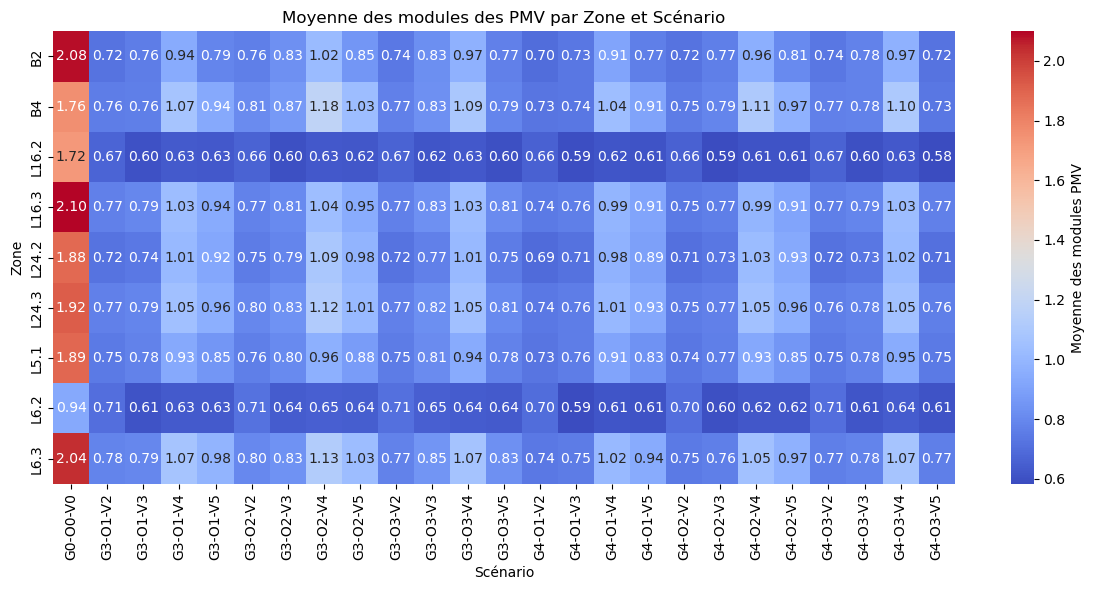

In [19]:
# =======================================================================
# Graphique 1 : Total d'heures d'inconfort par zone et scénario
# =======================================================================

# Étape 1 : Calcul des moyennes des modules des PMV par zone et scénario
# Filtrer les données pour le PMV
pmv_data = df[df['Indicateur'] == "Fanger PMV"].copy()  # Utiliser .copy() pour éviter le Warning

# Ajouter une colonne avec les modules des valeurs de PMV
pmv_data['Valeur_absolue'] = pmv_data['Valeur'].abs()

# Calcul de la moyenne des modules des PMV par zone et scénario
heatmap_data_pmv_abs = pmv_data.pivot_table(
    index='Zone', 
    columns='Scénario', 
    values='Valeur_absolue', 
    aggfunc='mean'  # Moyenne des modules
    
)

# Étape 2 : Création du graphique
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_pmv_abs, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Moyenne des modules PMV'})
plt.title("Moyenne des modules des PMV par Zone et Scénario")
plt.xlabel("Scénario")
plt.ylabel("Zone")
plt.tight_layout()
plt.show()

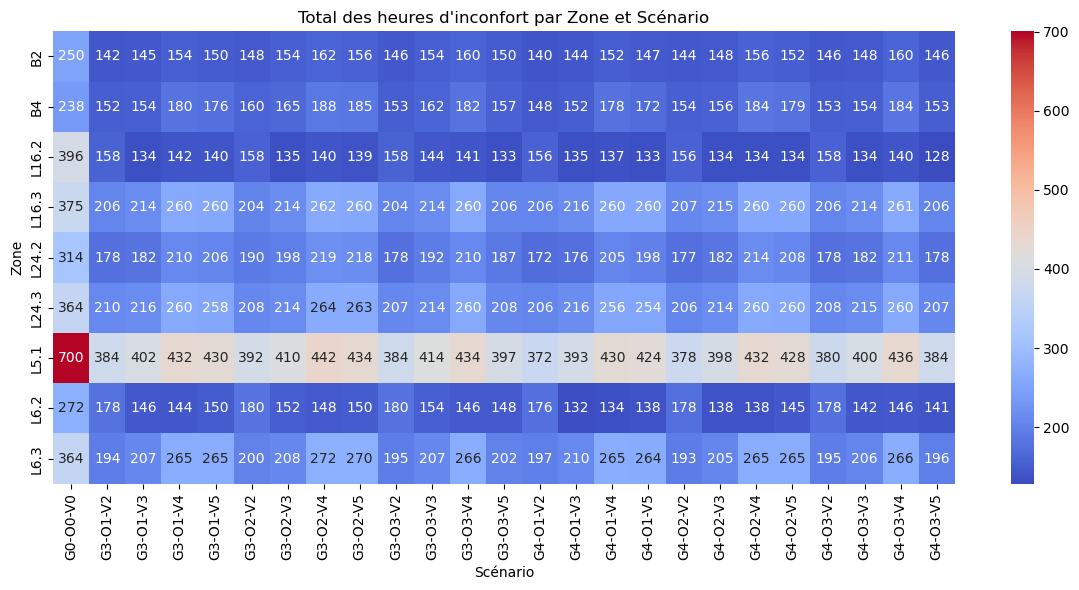

In [7]:
# =======================================================================
# Graphique 2 : Total d'heures d'inconfort par zone et scénario
# =======================================================================
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_sum, annot=True, cmap='coolwarm', fmt='.0f')
plt.title("Total des heures d'inconfort par Zone et Scénario")
plt.tight_layout()
plt.show()

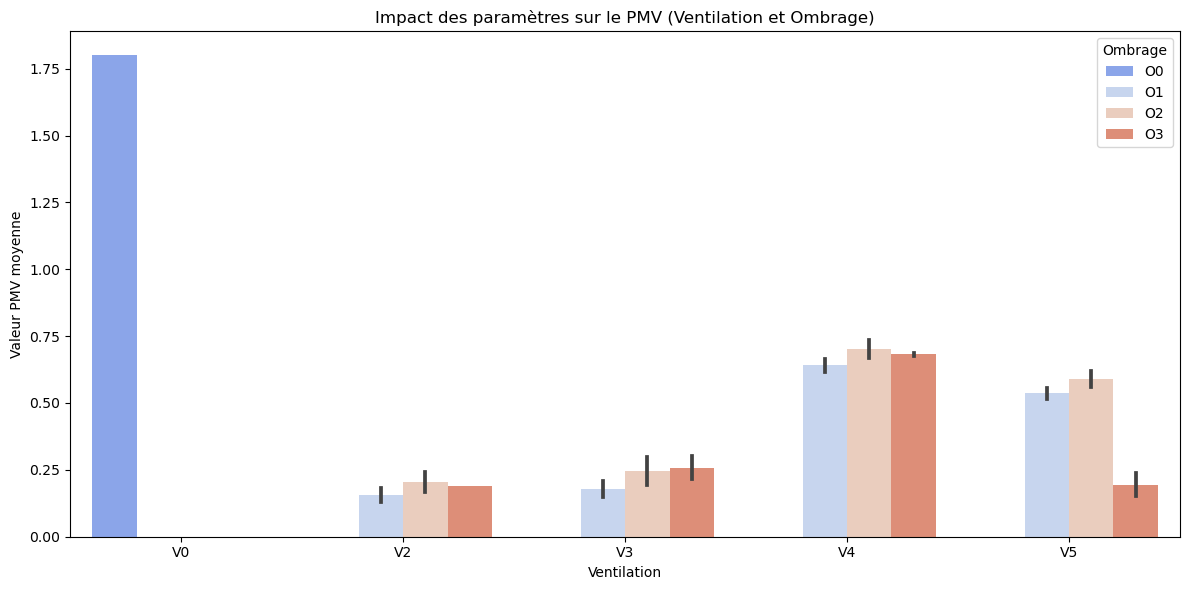

In [8]:
# =======================================================================
# Graphique 3 : Impact des paramètres sur le PMV (2D)
# =======================================================================
plt.figure(figsize=(12, 6))
sns.barplot(data=params_summary[params_summary['Indicateur'] == "Fanger PMV"], 
            x='Ventilation', y='Valeur', hue='Ombrage', palette='coolwarm')
plt.title("Impact des paramètres sur le PMV (Ventilation et Ombrage)")
plt.xlabel("Ventilation")
plt.ylabel("Valeur PMV moyenne")
plt.legend(title="Ombrage")
plt.tight_layout()
plt.show()

In [75]:
# =======================================================================
# Graphique 4 : Impact des paramètres sur le PMV (3D)
# =======================================================================
fig = px.scatter_3d(
    params_summary[params_summary['Indicateur'] == "Fanger PMV"],
    x='Ventilation', y='Ombrage', z='Valeur', color='Vitrage',
    title="Impact des paramètres sur le PMV (3D)",
    labels={'Ventilation': 'Ventilation', 'Ombrage': 'Ombrage', 'Valeur': 'PMV'},
    height=800, width=1000
)
fig.show()

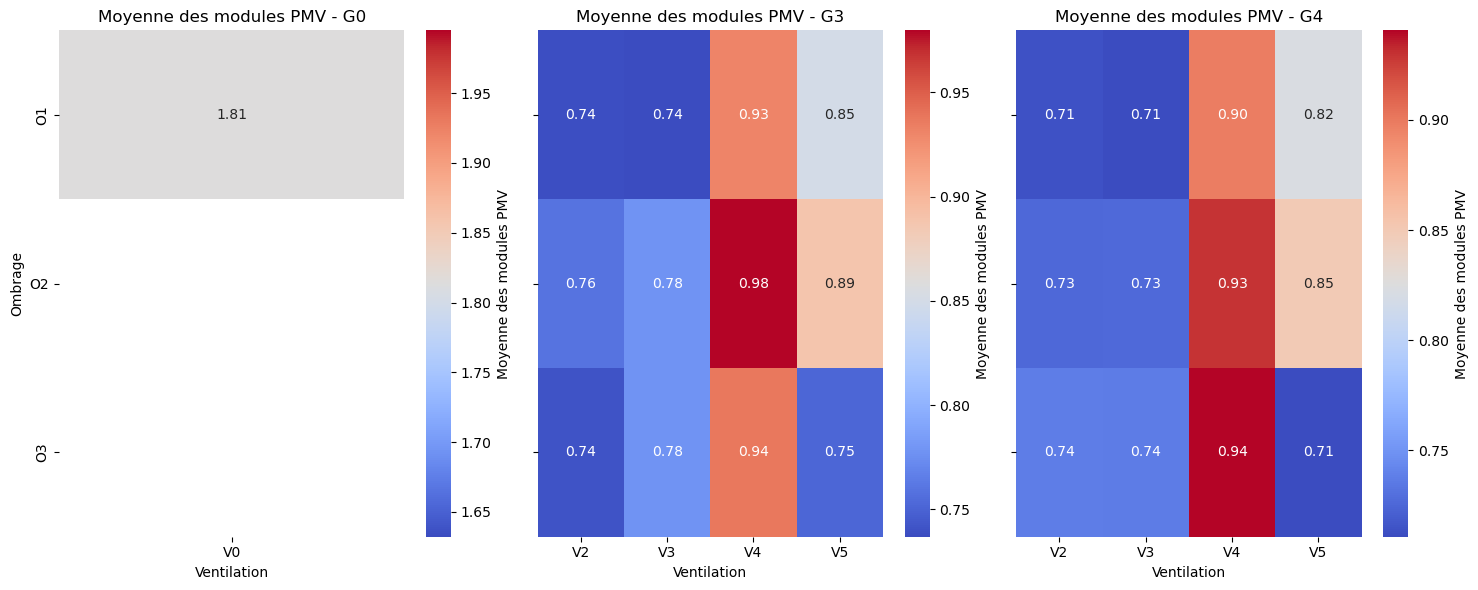

In [10]:
# =======================================================================
# Graphique 5 : Moyenne (modules des PMV) en fonction des paramètres (Ventilation, Ombrage, Vitrage)
# =======================================================================

# Étape 1 : Filtrer les données pour le PMV et ajouter la colonne des valeurs absolues
pmv_data = df[df['Indicateur'] == "Fanger PMV"].copy()
pmv_data['Valeur_absolue'] = pmv_data['Valeur'].abs()

# Étape 2 : Extraire les vitrages uniques
vitrages = pmv_data['Vitrage'].unique()

# Créer une figure avec un graphique par vitrage
fig, axes = plt.subplots(1, len(vitrages), figsize=(15, 6), sharey=True)

for i, vitrage in enumerate(vitrages):
    # Filtrer les données pour chaque vitrage
    vitrage_data = pmv_data[pmv_data['Vitrage'] == vitrage]

    # Calculer la moyenne des modules des PMV par combinaison de ventilation et ombrage
    heatmap_data = vitrage_data.pivot_table(
        index='Ombrage', 
        columns='Ventilation', 
        values='Valeur_absolue', 
        aggfunc='mean'
    )

    # Tracer le heatmap
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        cmap='coolwarm', #'RdYlGn_r' 'Spectral_r' 'coolwarm'
        fmt='.2f', 
        cbar_kws={'label': 'Moyenne des modules PMV'}, 
        ax=axes[i]
    )
    axes[i].set_title(f"Moyenne des modules PMV - {vitrage}")
    axes[i].set_xlabel("Ventilation")
    axes[i].set_ylabel("Ombrage" if i == 0 else "")

# Ajuster la mise en page
plt.tight_layout()
plt.show()

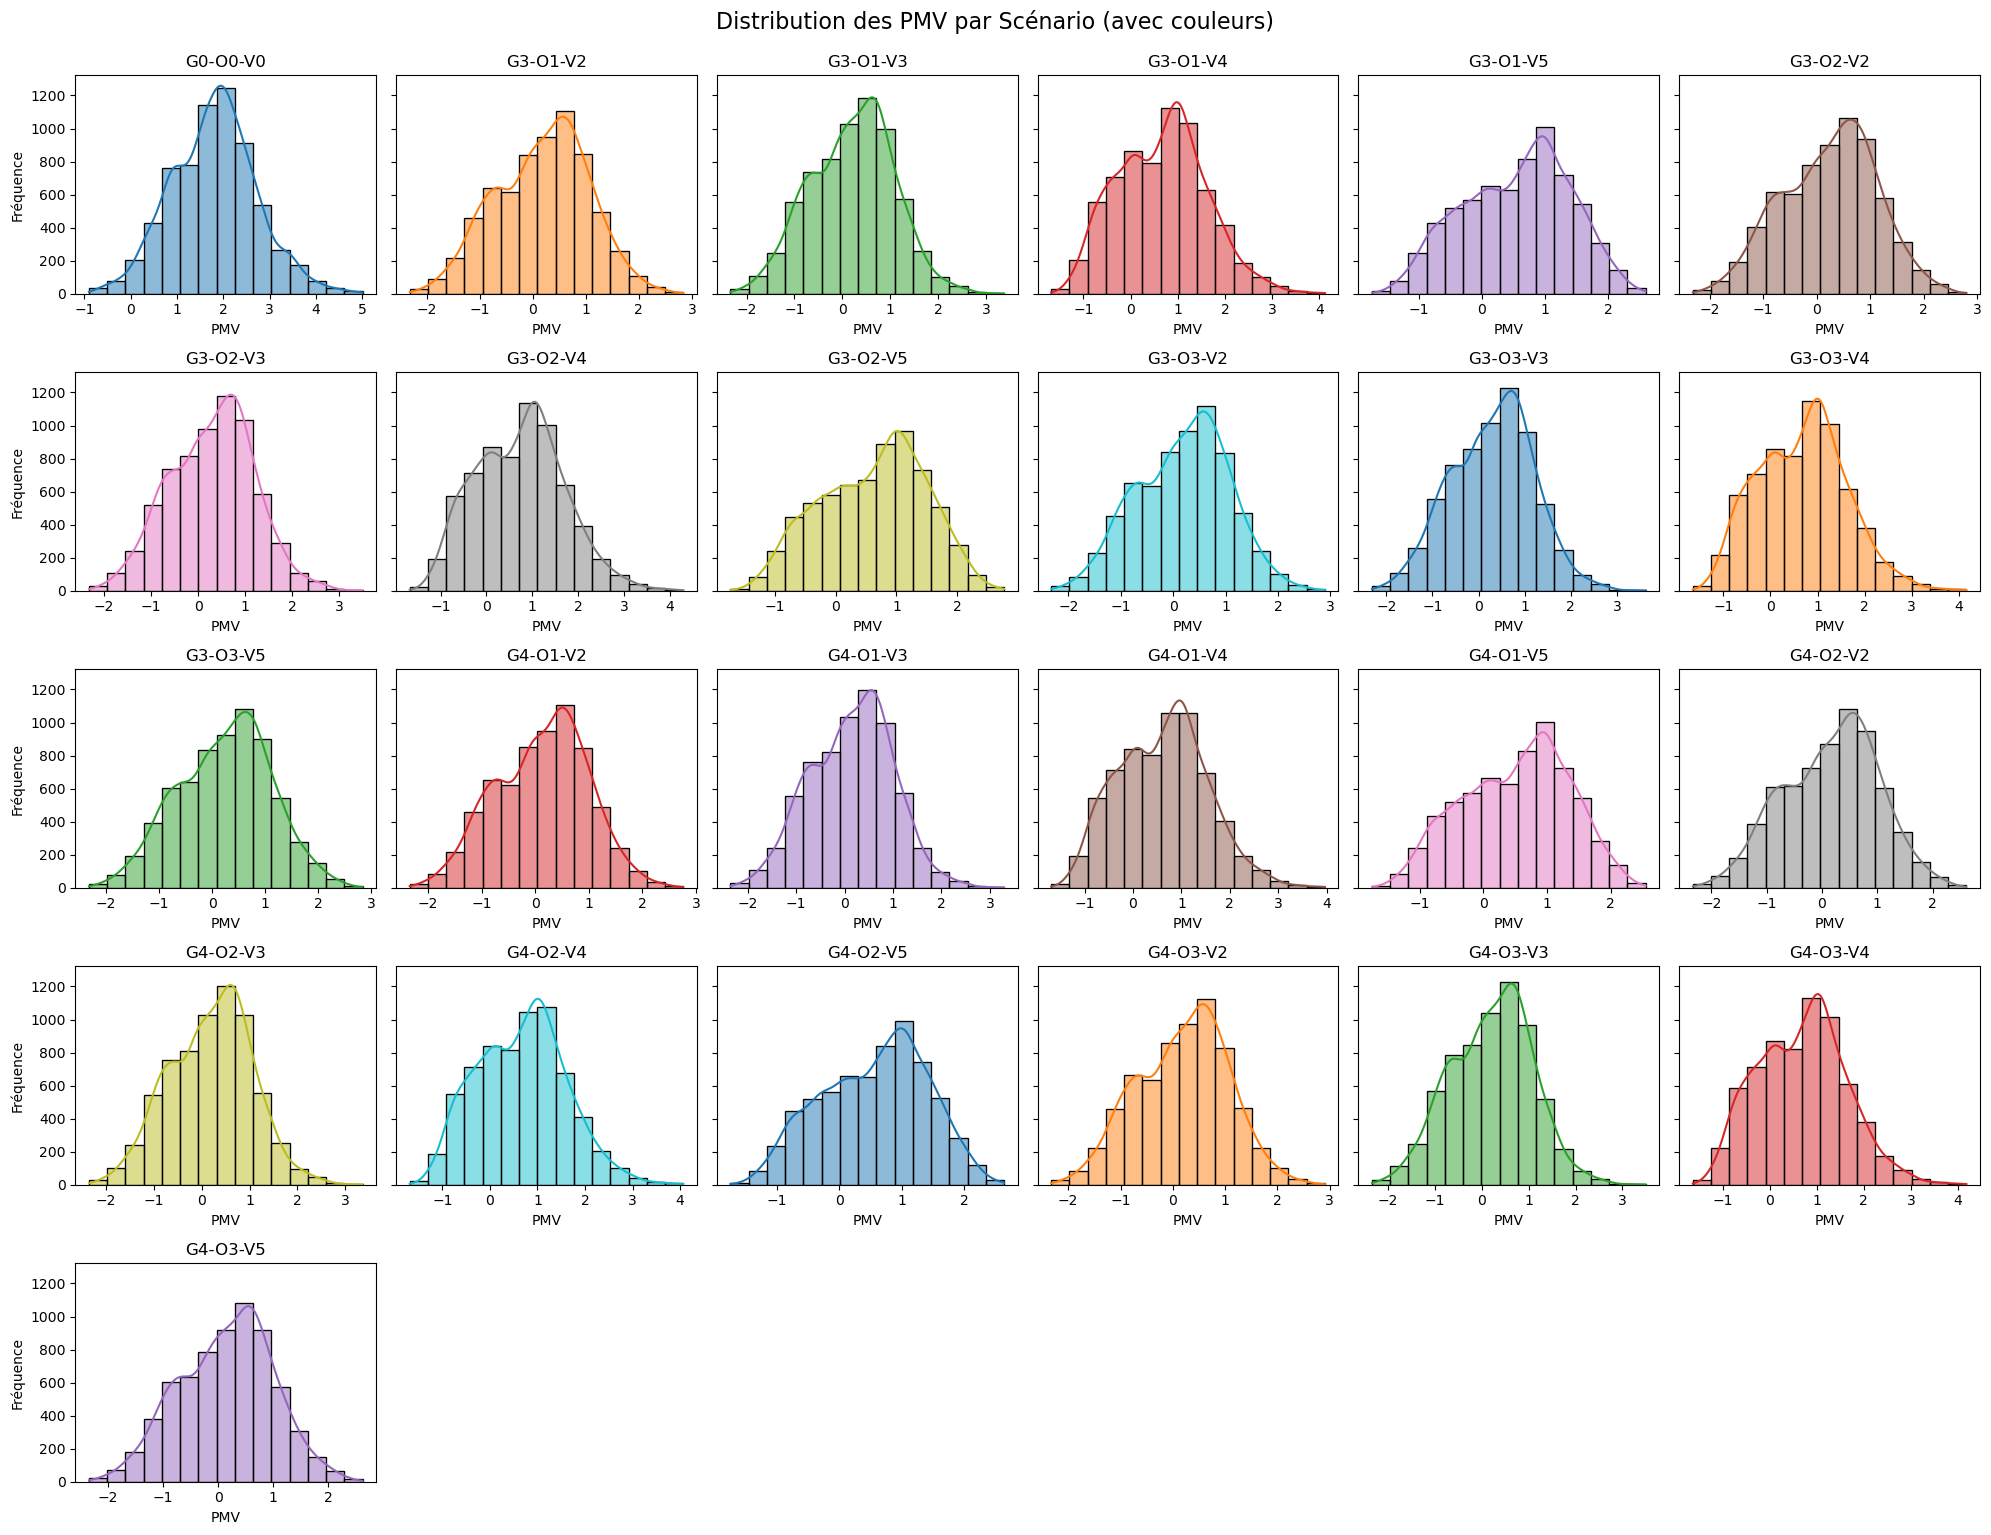

In [11]:
# =======================================================================
# Graphique 6 : Distribution des PMV par scénario
# =======================================================================
df_pmv = df[df['Indicateur'] == "Fanger PMV"]
scenarios = df_pmv['Scénario'].unique()

fig, axes = plt.subplots(nrows=len(scenarios) // 6 + 1, ncols=6, figsize=(20, 15), sharey=True)
axes = axes.flatten()

for i, scenario in enumerate(scenarios):
    sns.histplot(
        df_pmv[df_pmv['Scénario'] == scenario]['Valeur'], 
        bins=15, kde=True, ax=axes[i], color=f"C{i % 10}"
    )
    axes[i].set_title(scenario)
    axes[i].set_xlabel("PMV")
    axes[i].set_ylabel("Fréquence")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution des PMV par Scénario (avec couleurs)", y=1.02, fontsize=16)
plt.show()

In [77]:
# =======================================================================
# Graphique 7 : Évolution du PMV et du PPD
# =======================================================================

app = Dash(__name__)

# Layout de l'application Dash
app.layout = html.Div([
    html.H1("Évolution du PMV et du PPD", style={'text-align': 'center'}),
    
    html.Div([
        html.Label("Sélectionner un ou plusieurs scénarios :"),
        dcc.Dropdown(
            id='scenario-dropdown',
            options=[{'label': s, 'value': s} for s in df['Scénario'].unique()],
            value=[df['Scénario'].unique()[0]],  # Valeur par défaut
            multi=True  # Permet la sélection multiple
        ),
    ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    
    html.Div([
        html.Label("Sélectionner une zone :"),
        dcc.Dropdown(
            id='zone-dropdown',
            options=[{'label': z, 'value': z} for z in df['Zone'].unique()],
            value=df['Zone'].unique()[0]  # Valeur par défaut
        ),
    ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    
    html.Div([dcc.Graph(id='pmv-graph'),  # Graphique pour le PMV
              dcc.Graph(id='ppd-graph')])   # Graphique pour le PPD
])

# Callback pour mettre à jour les graphiques
@app.callback(
    [Output('pmv-graph', 'figure'),
     Output('ppd-graph', 'figure')],
    [Input('scenario-dropdown', 'value'), 
     Input('zone-dropdown', 'value')]
)
def update_graphs(selected_scenarios, selected_zone):
    if not selected_scenarios:
        return px.line(title="Aucun scénario sélectionné"), px.line(title="Aucun scénario sélectionné")
    
    # Filtrer les données pour les scénarios et la zone sélectionnés
    filtered_df = df[(df['Scénario'].isin(selected_scenarios)) & (df['Zone'] == selected_zone)].copy()

    # Vérifier si des données sont disponibles après filtrage
    if filtered_df.empty:
        return px.line(title="Aucune donnée pour le PMV"), px.line(title="Aucune donnée pour le PPD")
    
    # Trier les données par Date/Heure
    filtered_df = filtered_df.sort_values(by='Date/Heure')

    # Graphique pour le PMV
    pmv_df = filtered_df[filtered_df['Indicateur'] == "Fanger PMV"]
    pmv_fig = px.line(
        pmv_df,
        x='Date/Heure',
        y='Valeur',
        color='Scénario',  # Différencier les scénarios par couleur
        title=f"Évolution du PMV - Zone : {selected_zone}",
        labels={'Valeur': 'PMV', 'Date/Heure': 'Temps'},
        line_shape='linear'  # Retirer les points, uniquement des lignes
    )
    pmv_fig.update_layout(
        height=400,
        width=800,
        legend_title_text="Scénarios",
        margin=dict(l=20, r=20, t=50, b=20)
    )
    
    # Graphique pour le PPD
    ppd_df = filtered_df[filtered_df['Indicateur'] == "PPD"]
    ppd_fig = px.line(
        ppd_df,
        x='Date/Heure',
        y='Valeur',
        color='Scénario',  # Différencier les scénarios par couleur
        title=f"Évolution du PPD - Zone : {selected_zone}",
        labels={'Valeur': 'PPD (%)', 'Date/Heure': 'Temps'},
        line_shape='linear'  # Retirer les points, uniquement des lignes
    )
    ppd_fig.update_layout(
        height=400,
        width=800,
        legend_title_text="Scénarios",
        margin=dict(l=20, r=20, t=50, b=20)
    )
    
    return pmv_fig, ppd_fig

# Lancer l'application Dash
if __name__ == '__main__':
    app.run_server(debug=True, port=8072)

In [78]:
# =======================================================================
# Graphique 9 : Comparaison des Scénarios (Distribution des PMV)
# =======================================================================

# Application Dash
app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.H1("Comparaison des Scénarios (Courbes de densité des PMV)", style={'text-align': 'center'}),
    
    html.Div([
        html.Label("Sélectionner les scénarios :"),
        dcc.Dropdown(
            id='scenario-dropdown',
            options=[{'label': s, 'value': s} for s in df['Scénario'].unique()],
            value=[df['Scénario'].unique()[0]],  # Valeurs par défaut
            multi=True  # Permet de choisir plusieurs scénarios
        ),
    ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    
    html.Div([
        html.Label("Sélectionner une zone thermique :"),
        dcc.Dropdown(
            id='zone-dropdown',
            options=[{'label': z, 'value': z} for z in df['Zone'].unique()],
            value=df['Zone'].unique()[0]  # Valeur par défaut
        ),
    ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    
    dcc.Graph(id='pmv-density-curve'),
])

# Callback pour mettre à jour le graphique
@app.callback(
    Output('pmv-density-curve', 'figure'),
    [Input('scenario-dropdown', 'value'), Input('zone-dropdown', 'value')]
)
def update_graph(selected_scenarios, selected_zone):
    # Filtrer les données pour les scénarios sélectionnés et la zone
    filtered_df = df[(df['Scénario'].isin(selected_scenarios)) & 
                     (df['Zone'] == selected_zone) & 
                     (df['Indicateur'] == "Fanger PMV")]
    
    # Créer une figure vide
    fig = go.Figure()

    for scenario in selected_scenarios:
        # Extraire les valeurs pour le scénario
        scenario_df = filtered_df[filtered_df['Scénario'] == scenario]['Valeur']

        if not scenario_df.empty:
            # Calculer une courbe de densité
            kde = gaussian_kde(scenario_df)
            x_vals = np.linspace(scenario_df.min() - 0.5, scenario_df.max() + 0.5, 500)
            y_vals = kde(x_vals)
            
            # Ajouter une trace pour la courbe
            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals, mode='lines', name=scenario,
                line=dict(width=2)  # Personnalisation de la ligne
            ))

    # Mettre à jour les paramètres du graphique
    fig.update_layout(
        title=f"Courbes de densité des PMV (Zone : {selected_zone})",
        xaxis_title="PMV",
        yaxis_title="Densité",
        height=600,
        width=1000,
        legend_title="Scénarios",
    )

    return fig

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8074)

In [79]:
# =======================================================================
# Graphique 11 : Analyse des indicateurs par scénario
# =======================================================================

# Préparation des données

# Liste des indicateurs disponibles
indicateurs = ["Fanger PMV", "PPD", "Température opérative", "Heures d'inconfort (tout type de vêtement)"]

# Création de l'application Dash
app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.H1("Analyse des indicateurs par scénario", style={'text-align': 'center'}),

    # Filtres interactifs
    html.Div([
        html.Div([
            html.Label("Sélectionner la mesure statistique :"),
            dcc.Dropdown(
                id='statistic-dropdown',
                options=[
                    {'label': 'Médiane', 'value': 'median'},
                    {'label': 'Moyenne', 'value': 'mean'},
                    {'label': 'Moyenne des valeurs absolues', 'value': 'mean_abs'},
                    {'label': 'Intégrale', 'value': 'integral'}
                ],
                value='median',  # Valeur par défaut
                multi=False
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),

        html.Div([
            html.Label("Sélectionner un indicateur :"),
            dcc.Dropdown(
                id='indicator-dropdown',
                options=[{'label': indic, 'value': indic} for indic in indicateurs],
                value='Fanger PMV',  # Valeur par défaut
                multi=False
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    ]),

    # Graphique interactif
    dcc.Graph(id='indicator-graph')
])

# Callback pour mettre à jour le graphique
@app.callback(
    Output('indicator-graph', 'figure'),
    [Input('statistic-dropdown', 'value'),
     Input('indicator-dropdown', 'value')]
)
def update_graph(selected_statistic, selected_indicator):
    # Filtrer les données pour l'indicateur sélectionné
    filtered_df = df[df['Indicateur'] == selected_indicator]

    # Calcul de la statistique par scénario
    if selected_statistic == 'median':
        stat_df = filtered_df.groupby('Scénario')['Valeur'].median().reset_index(name='Valeur')
        title = f"Médiane de {selected_indicator} par scénario"
    elif selected_statistic == 'mean':
        stat_df = filtered_df.groupby('Scénario')['Valeur'].mean().reset_index(name='Valeur')
        title = f"Moyenne de {selected_indicator} par scénario"
    elif selected_statistic == 'mean_abs':
        stat_df = filtered_df.groupby('Scénario')['Valeur'].apply(lambda x: abs(x).mean()).reset_index(name='Valeur')
        title = f"Moyenne des valeurs absolues de {selected_indicator} par scénario"
    elif selected_statistic == 'integral':
        # Approximation de l'intégrale (somme des valeurs)
        stat_df = filtered_df.groupby('Scénario')['Valeur'].sum().reset_index(name='Valeur')
        title = f"Intégrale (aire sous la courbe) de {selected_indicator} par scénario"

    # Créer le graphique
    fig = px.bar(
        stat_df,
        x='Scénario',
        y='Valeur',
        title=title,
        labels={'Valeur': selected_indicator, 'Scénario': 'Scénario'},
        height=600
    )

    # Ajuster les options de mise en page
    fig.update_layout(
        xaxis=dict(title="Scénario", tickangle=45),
        yaxis=dict(title=f"Valeur ({selected_indicator})"),
        margin=dict(l=20, r=20, t=50, b=20)
    )

    return fig

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8076)

In [80]:
# =======================================================================
# Chargement et préparation des données
# =======================================================================

# Convertir la colonne Date/Heure en datetime
df['Date/Heure'] = pd.to_datetime(df['Date/Heure'])

# Identifier les heures d’inconfort (> 0)
df['Inconfort'] = df['Valeur'] > 0

# Nouvelle approche : Détection stricte des séquences
def detect_inconfort_sequences(data):
    """ Fonction améliorée pour détecter correctement les heures isolées d'inconfort et les séquences. """
    result = []

    for (zone, scenario), group in data.groupby(["Zone", "Scénario"]):
        group = group.sort_values("Date/Heure")  # Trier par temps
        
        # Création d'un identifiant de séquence unique
        group['Groupe'] = (group['Inconfort'] != group['Inconfort'].shift()).cumsum()
        
        # Regroupement des séquences
        grouped = group.groupby(['Groupe', 'Inconfort']).size().reset_index(name='Durée')

        for _, row in grouped.iterrows():
            if row['Inconfort']:  # Ne conserver que les périodes d'inconfort
                result.append({"Zone": zone, "Scénario": scenario, "Durée": row['Durée']})

    return pd.DataFrame(result)

# Appliquer la détection des séquences
df_inconfort_sequences = detect_inconfort_sequences(df)


# Regrouper les durées d’inconfort en plages
df_inconfort_sequences['Plage_durée'] = pd.cut(
    df_inconfort_sequences['Durée'],
    bins=[0, 1, 2, 4, 6, 12, 24, float('inf')],
    labels=['1h', '2h', '3-4h', '5-6h', '7-12h', '13-24h', '24+h'],
    right=True
)

# Compter les occurrences des durées d'inconfort par scénario et zone
df_durations_summary = df_inconfort_sequences.groupby(['Zone', 'Scénario', 'Plage_durée']).size().reset_index(name='Occurrences')


# =======================================================================
# Création de l'application Dash
# =======================================================================

app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.H1("Analyse des durées d'inconfort", style={'text-align': 'center'}),

    # Sélection des zones et scénarios
    html.Div([
        html.Div([
            html.Label("Sélectionner une zone thermique :"),
            dcc.Dropdown(
                id='zone-dropdown',
                options=[{'label': zone, 'value': zone} for zone in df_durations_summary['Zone'].unique()],
                value=df_durations_summary['Zone'].unique()[0],  # Valeur par défaut
                multi=False
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),

        html.Div([
            html.Label("Sélectionner un ou plusieurs scénarios :"),
            dcc.Dropdown(
                id='scenario-dropdown',
                options=[{'label': scenario, 'value': scenario} for scenario in df_durations_summary['Scénario'].unique()],
                multi=True,
                value=df_durations_summary['Scénario'].unique()[:3]  # Sélection par défaut
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    ]),

    # Graphique interactif
    dcc.Graph(id='inconfort-graph')
])

# =======================================================================
# Callback pour mettre à jour le graphique
# =======================================================================

@app.callback(
    Output('inconfort-graph', 'figure'),
    [Input('zone-dropdown', 'value'),
     Input('scenario-dropdown', 'value')]
)
def update_graph(selected_zone, selected_scenarios):
    # Filtrer les données en fonction des sélections
    filtered_df = df_durations_summary[
        (df_durations_summary['Zone'] == selected_zone) &
        (df_durations_summary['Scénario'].isin(selected_scenarios))
    ]


    # Créer le graphique interactif
    fig = px.bar(
        filtered_df,
        x='Plage_durée', 
        y='Occurrences', 
        color='Scénario',
        barmode='group',
        title=f"Durées consécutives d'inconfort - Zone : {selected_zone}",
        labels={'Plage_durée': 'Durées consécutives (heures)', 'Occurrences': 'Nombre d\'occurrences'},
        height=600
    )

    # Ajuster la mise en page
    fig.update_layout(
        showlegend=True,
        legend_title_text="Scénarios",
        margin=dict(l=20, r=20, t=40, b=20),
        font=dict(size=10)
    )

    return fig

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8078)

In [62]:
# ============================
# 📊 Préparation du Tableau Multi-Tri Simultané
# ============================

# Chargement des données existantes
df_table = df_table.copy()

# Ajout des classements pour chaque indicateur (ordre croissant)
df_table['Rang_PMV'] = df_table['PMV'].rank(method="min", ascending=True).astype(int)
df_table['Rang_PPD'] = df_table['PPD'].rank(method="min", ascending=True).astype(int)
df_table['Rang_ISI'] = df_table['ISI'].rank(method="min", ascending=True).astype(int)
df_table['Rang_Heures'] = df_table['Total_Heures'].rank(method="min", ascending=True).astype(int)

# Réorganisation des colonnes
df_table_sorted = df_table[['Scénario', 'PMV', 'Rang_PMV', 'PPD', 'Rang_PPD', 'ISI', 'Rang_ISI', 'Total_Heures', 'Rang_Heures']]

# Tri global des scénarios par ordre croissant de PMV, PPD et ISI
df_table_sorted = df_table_sorted.sort_values(by=['Rang_PMV', 'Rang_PPD', 'Rang_ISI'], ascending=[True, True, True])

# Affichage du tableau final
print(df_table_sorted)  # 📌 Affichage dans la console

    Scénario       PMV  Rang_PMV        PPD  Rang_PPD         ISI  Rang_ISI  \
14  G4-O1-V3  0.710744         1  20.134367         1   43.389577         2   
24  G4-O3-V5  0.711627         2  20.179818         2   42.018724         1   
13  G4-O1-V2  0.714271         3  20.250809         3   44.185426         3   
17  G4-O2-V2  0.725253         4  20.564406         4   46.344269        10   
18  G4-O2-V3  0.726758         5  20.653281         5   45.254897         4   
22  G4-O3-V3  0.736624         6  21.009413         6   45.926961         9   
2   G3-O1-V3  0.736831         7  21.060064         8   45.753854         6   
21  G4-O3-V2  0.737410         8  21.028935         7   45.755690         7   
1   G3-O1-V2  0.738255         9  21.103187         9   46.499565        11   
9   G3-O3-V2  0.740782        10  21.163391        10   45.868956         8   
12  G3-O3-V5  0.751627        11  21.616591        11   45.637609         5   
5   G3-O2-V2  0.759361        12  21.801345        1

In [81]:
from dash import Dash, dcc, html, dash_table, Input, Output
import pandas as pd

# ============================
# 📊 Création de l'Application Dash - Vue Multicolonne
# ============================

# Création de l'application Dash
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Comparaison Dynamique des Classements", style={'text-align': 'center'}),

    # Sélecteur de tri
    html.Div([
        html.Label("Trier par :"),
        dcc.Dropdown(
            id='sort-dropdown',
            options=[
                {'label': 'PMV (croissant)', 'value': 'Rang_PMV'},
                {'label': 'PPD (croissant)', 'value': 'Rang_PPD'},
                {'label': 'Sévérité d’Inconfort (ISI)', 'value': 'Rang_ISI'},
                {'label': 'Total Heures (croissant)', 'value': 'Rang_Heures'}
            ],
            value='Rang_PMV',
            multi=False
        ),
    ], style={'width': '50%', 'margin': 'auto'}),

    # Tableau interactif
    dash_table.DataTable(
        id='table',
        columns=[
            {'name': 'Scénario', 'id': 'Scénario'},
            {'name': 'PMV', 'id': 'PMV', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang PMV', 'id': 'Rang_PMV'},
            {'name': 'PPD', 'id': 'PPD', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang PPD', 'id': 'Rang_PPD'},
            {'name': 'ISI (Inconfort)', 'id': 'ISI', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang ISI', 'id': 'Rang_ISI'},
            {'name': 'Total Heures', 'id': 'Total_Heures', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang Heures', 'id': 'Rang_Heures'}
        ],
        data=df_table_sorted.to_dict('records'),
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'center', 'padding': '5px'},
        style_header={'backgroundColor': 'lightblue', 'fontWeight': 'bold'},
        style_data_conditional=[
            {'if': {'row_index': 0}, 'backgroundColor': '#FFD700', 'color': 'black', 'fontWeight': 'bold'},  # 🥇 Or
            {'if': {'row_index': 1}, 'backgroundColor': '#C0C0C0', 'color': 'black', 'fontWeight': 'bold'},  # 🥈 Argent
            {'if': {'row_index': 2}, 'backgroundColor': '#CD7F32', 'color': 'black', 'fontWeight': 'bold'},  # 🥉 Bronze
        ],
    )
])

# Callback pour mettre à jour le tri
@app.callback(
    Output('table', 'data'),
    [Input('sort-dropdown', 'value')]
)
def update_table(selected_sort):
    df_sorted = df_table_sorted.sort_values(by=selected_sort, ascending=True)
    return df_sorted.to_dict('records')

# ============================
# Lancement de l'application
# ============================
if __name__ == '__main__':
    app.run_server(debug=True, port=8083)

In [82]:
from dash import Dash, dcc, html, dash_table, Input, Output
import pandas as pd

# ============================
# 📊 Création de l'Application Dash - Vue Multicolonne
# ============================

# Création de l'application Dash
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Comparaison Dynamique des Classements", style={'text-align': 'center'}),

    # Sélecteur de tri
    html.Div([
        html.Label("Trier par :"),
        dcc.Dropdown(
            id='sort-dropdown',
            options=[
                {'label': 'PMV (croissant)', 'value': 'Rang_PMV'},
                {'label': 'PPD (croissant)', 'value': 'Rang_PPD'},
                {'label': 'Sévérité d’Inconfort (ISI)', 'value': 'Rang_ISI'},
                {'label': 'Total Heures (croissant)', 'value': 'Rang_Heures'}
            ],
            value='Rang_PMV',
            multi=False
        ),
    ], style={'width': '50%', 'margin': 'auto'}),

    # Tableau interactif
    dash_table.DataTable(
        id='table',
        columns=[
            {'name': 'Scénario', 'id': 'Scénario'},
            {'name': 'PMV', 'id': 'PMV', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang PMV', 'id': 'Rang_PMV'},
            {'name': 'PPD', 'id': 'PPD', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang PPD', 'id': 'Rang_PPD'},
            {'name': 'ISI (Inconfort)', 'id': 'ISI', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang ISI', 'id': 'Rang_ISI'},
            {'name': 'Total Heures', 'id': 'Total_Heures', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang Heures', 'id': 'Rang_Heures'}
        ],
        data=df_table_sorted.to_dict('records'),
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'center', 'padding': '5px'},
        style_header={'backgroundColor': 'lightblue', 'fontWeight': 'bold'},
        style_data_conditional=[
            {'if': {'row_index': 0}, 'backgroundColor': '#FFD700', 'color': 'black', 'fontWeight': 'bold'},  # 🥇 Or
            {'if': {'row_index': 1}, 'backgroundColor': '#C0C0C0', 'color': 'black', 'fontWeight': 'bold'},  # 🥈 Argent
            {'if': {'row_index': 2}, 'backgroundColor': '#CD7F32', 'color': 'black', 'fontWeight': 'bold'},  # 🥉 Bronze
        ],
    ),

    # ✅ Bouton pour exporter l'HTML interactif
    html.Button("Exporter en HTML", id="btn-download", n_clicks=0),
    dcc.Download(id="download-html")
])

# Callback pour mettre à jour le tri
@app.callback(
    Output('table', 'data'),
    [Input('sort-dropdown', 'value')]
)
def update_table(selected_sort):
    df_sorted = df_table_sorted.sort_values(by=selected_sort, ascending=True)
    return df_sorted.to_dict('records')

# ✅ Callback pour exporter en fichier HTML
@app.callback(
    Output("download-html", "data"),
    Input("btn-download", "n_clicks"),
    prevent_initial_call=True
)
def export_html(n_clicks):
    file_path = "tableau_interactif.html"
    
    # Générer une page HTML contenant l'application Dash
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(app.index_string)
    
    return dcc.send_file(file_path)

# ============================
# Lancement de l'application
# ============================
if __name__ == '__main__':
    app.run_server(debug=True, port=8084)